In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [5]:
# !pip install --upgrade pip
!pip install -r yolov5/requirements.txt --ignore-installed

Looking in indexes: http://pip-notebook.modelarts.com:8888/repository/pypi/simple/
     |████████████████████████████████| 11.5 MB 47.5 MB/s                                | 3.7 MB 47.5 MB/s eta 0:00:01    |█████████████████████████▉      | 9.3 MB 47.5 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 44.4 MB/s            B 44.4 MB/s eta 0:00:01MB/s eta 0:00:01
     |████████████████████████████████| 60.3 MB 44.4 MB/s            a 0:00:02/s eta 0:00:02                   | 17.9 MB 44.4 MB/s eta 0:00:01           | 22.8 MB 44.4 MB/s eta 0:00:01         | 29.0 MB 44.4 MB/s eta 0:00:01  |██████████████████▍             | 34.7 MB 44.4 MB/s eta 0:00:01��██▉          | 41.1 MB 44.4 MB/s eta 0:00:01��       | 46.8 MB 44.4 MB/s eta 0:00:01�███▍    | 51.6 MB 44.4 MB/s eta 0:00:01�████████████▋ | 57.6 MB 44.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 49.5 MB/s                        | 1.1 MB 49.5 MB/s eta 0:00:01
     |████████████████████████████████| 603 kB 

In [6]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import cv2

random.seed(108)


Bad key text.latex.unicode in file /home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You pr

# Prepare

## Getting Data

In [1]:
import os
if not os.path.exists('./rebar_count_datasets'):
    print('Downloading code and datasets...')
    os.system("wget -N https://cnnorth4-modelhub-datasets-obsfs-sfnua.obs.cn-north-4.myhuaweicloud.com/content/c2c1853f-d6a6-4c9d-ac0e-203d4c304c88/NkxX5K/dataset/rebar_count_datasets.zip")
    os.system("unzip -q rebar_count_datasets.zip; rm rebar_count_datasets.zip")
    if os.path.exists('./rebar_count_datasets'):
        print('Download code and datasets success')
    else:
        print('Download code and datasets failed, please check the download url is valid or not.')
else:
    print('./rebar_count_datasets already exists')

Download code and datasets success


## Convert Annotation ke format YOLO v5

In [17]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text[19:]
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [19]:
class_name_to_id_mapping = {"steel": 0}

def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("rebar_count_datasets/VOC2007/Annotations", info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [20]:
# Get the annotations
annotations = [os.path.join('rebar_count_datasets/VOC2007/Annotations/', x) for x in os.listdir('rebar_count_datasets/VOC2007/Annotations/') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('rebar_count_datasets/VOC2007/Annotations/', x) for x in os.listdir('rebar_count_datasets/VOC2007/Annotations/') if x[-3:] == "txt"]

100%|██████████| 250/250 [00:00<00:00, 502.03it/s]


### Testing

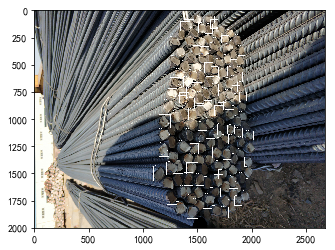

In [22]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("rebar_count_datasets/VOC2007/Annotations/", "rebar_count_datasets/VOC2007/JPEGImages/").replace("txt", "jpg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

## Partitions the Dataset

In [26]:
# Read images and annotations
images = [os.path.join('rebar_count_datasets/VOC2007/JPEGImages', x) for x in os.listdir('rebar_count_datasets/VOC2007/JPEGImages')]
annotations = [os.path.join('rebar_count_datasets/VOC2007/Annotations', x) for x in os.listdir('rebar_count_datasets/VOC2007/Annotations') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [29]:
# make folder
!mkdir rebar_count_datasets/VOC2007/JPEGImages/train rebar_count_datasets/VOC2007/JPEGImages/val rebar_count_datasets/VOC2007/JPEGImages/test rebar_count_datasets/VOC2007/Annotations/train rebar_count_datasets/VOC2007/Annotations/val rebar_count_datasets/VOC2007/Annotations/test

In [30]:
# move to corresponding folder
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'rebar_count_datasets/VOC2007/JPEGImages/train')
move_files_to_folder(val_images, 'rebar_count_datasets/VOC2007/JPEGImages/val/')
move_files_to_folder(test_images, 'rebar_count_datasets/VOC2007/JPEGImages/test/')
move_files_to_folder(train_annotations, 'rebar_count_datasets/VOC2007/Annotations/train/')
move_files_to_folder(val_annotations, 'rebar_count_datasets/VOC2007/Annotations/val/')
move_files_to_folder(test_annotations, 'rebar_count_datasets/VOC2007/Annotations/test/')

In [32]:
# change folder name
!mv rebar_count_datasets/VOC2007/Annotations rebar_count_datasets/VOC2007/labels
!mv rebar_count_datasets/VOC2007/JPEGImages rebar_count_datasets/VOC2007/images

# Training

Create a new file called `rebar_data.yaml` and place it in the `yolov5/data folder`. Then populate it with the following.

```
train: ../rebar_count_datasets/VOC2007/images/train/
val:  ../rebar_count_datasets/VOC2007/images/val/
test: ../rebar_count_datasets/VOC2007/images/test/

# number of classes
nc: 1

# class names
names: ["steel"]
```

## Train the Model

In [59]:
!cd yolov5 && python train.py --img 480 --cfg yolov5s.yaml --hyp hyp.scratch.yaml --batch 16 --epochs 100 --data rebar_data.yaml --weights yolov5s.pt --workers 24 --name yolo_rebar_det

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=rebar_data.yaml, hyp=hyp.scratch.yaml, epochs=100, batch_size=16, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=24, project=runs/train, name=yolo_rebar_det, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (offline), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v6.0-39-g5d4258f torch 1.10.0+cu102 CUDA:0 (Tesla V100-SXM2-16GB, 16160.5MB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, 

# Prediction

In [32]:
!cd yolov5 && python detect.py --source ../rebar_count_datasets/test_dataset/ --weights runs/train/yolo_rebar_det6/weights/best.pt --conf 0.25 --name yolo_rebar_det --save-txt


Bad key text.latex.unicode in file /home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /home/ma-user/anaconda3/envs/Pytorch-1.0.0/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You pr

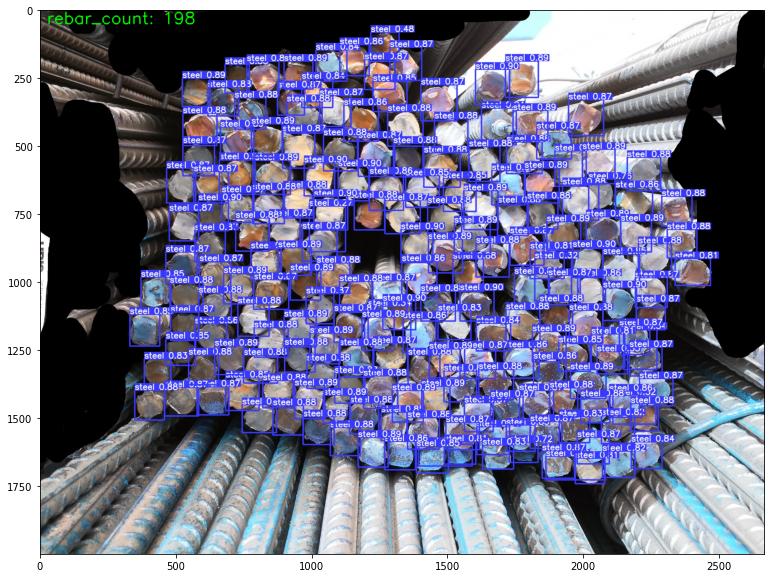

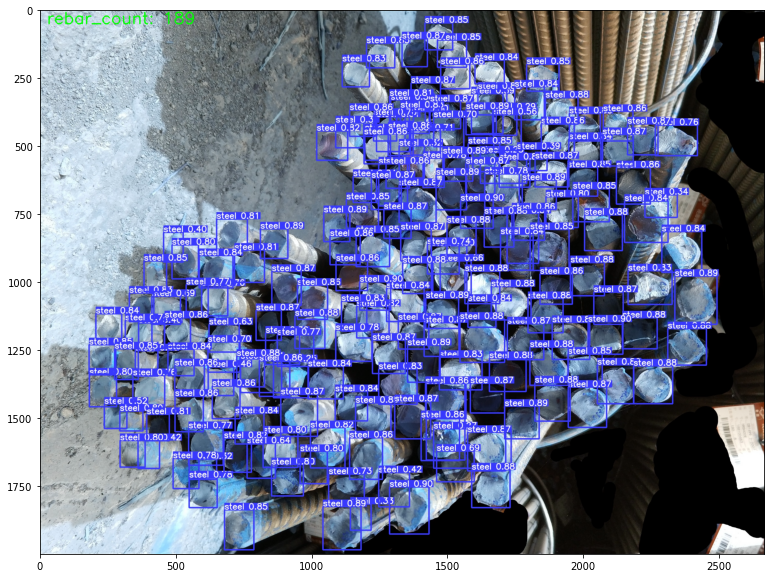

In [35]:
detections_dir = "yolov5/runs/detect/yolo_rebar_det/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

for i in detection_images[:2]:
    image_src = cv2.imread(i)
    image_draw = image_src.copy()
    label_file = i[:-12] + "labels/" + i[-12:-3] + "txt"
    label = open(label_file).readlines()
    
    cv2.putText(image_draw, f'rebar_count: {len(label)}', (25,50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
    plt.figure(figsize=(20,10))
    plt.imshow(image_draw)
    plt.show